**Main imports**

In [6]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [ ]:
# helper function to make getting another batch of data easier
'''
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')
'''
import torchvision.transforms as transforms
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

# Define the transform for non-augmented data.
nonaug_transform = transforms.Compose([
    transforms.ToTensor()
])

'''

Did not have the space to write about this in my report.

My data augmentation strategy was a simple random horizontal flip.
Any operation that left visual artefacts (such as the black borders created by scales and rotations) were learned by the generator and were seen in the generated images as well.

'''
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset_nonaug = torchvision.datasets.CIFAR100(
    'data', train=True, download=True, transform=nonaug_transform)

train_dataset_aug = torchvision.datasets.CIFAR100(
    'data', train=True, download=True, transform=aug_transform)

train_dataset_combined = torch.utils.data.ConcatDataset([train_dataset_nonaug, train_dataset_aug])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.CIFAR100(
    'data', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset_combined, batch_size=256, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=
    256
    , drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_dataset_combined)}')
print(f'> Size of test dataset {len(test_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 100000
> Size of test dataset 10000


**View some of the test dataset**

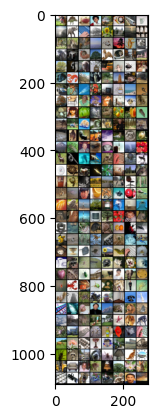

In [ ]:
# let's view some of the training data
'''

All code within this block is the property of Amir-Atapour-Abarghouei

'''

plt.rcParams['figure.dpi'] = 100
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

**DCGAN with spectral normalisation and self attention layers**

In [9]:
from torch.nn.utils import spectral_norm

class DCGANGenerator(nn.Module):

    def __init__(self, latent_dim=110, img_channels=3, base_channels=44):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Project from latent space into a base_channels x 4 x 4 feature map
        self.project = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, base_channels * 4, 4, 1 ,0 , bias=False),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(True)
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(True),
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(True),
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(base_channels, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), self.latent_dim, 1, 1)
        x = self.project(z)  # (batch_size, base_channels*4*4)
        x = self.up1(x)      # 4×4 -> 8×8
        #x, p1 = self.sp1(x)
        x = self.up2(x)      # 8×8 -> 16×16
        #x, p2 = self.sp2(x)
        x = self.last(x)      # 16×16 -> 32×32
        return x


class DCGANDiscriminator(nn.Module):
    def __init__(self, img_channels=3, base_channels=44):
        super().__init__()

        self.down1 = nn.Sequential(
            spectral_norm(nn.Conv2d(img_channels, base_channels, kernel_size=4, stride=2, padding=1, bias = False)),
            #nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.down2 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels, base_channels * 2, kernel_size=4, stride=2, padding=1, bias = False)),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.down3 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels * 2, base_channels * 4 , kernel_size=4, stride=2, padding=1, bias = False)),
            nn.BatchNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )


        # final feature map is (batch_size, base_channels, 2, 2) = base_channels * 2 * 2
        self.fc = nn.Conv2d(base_channels * 4, 1, 4, 1, 0, bias = False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.down1(x)  # 32×32 -> 16×16
        x = self.down2(x)  # 16×16 -> 8×8
        #x, p1 = self.sp1(x)
        x = self.down3(x)  # 8×8 -> 4×4
        #x, p2= self.sp2(x)

        x = self.fc(x)
        x = x.view(x.size(0), -1) 
        return self.sigmoid(x)
    

params = {
    'batch_size': train_loader.batch_size,
    'n_channels': 3,
    'n_latent': 110, # alters number of parameters
    'n_classes': len(class_names)
}

G = DCGANGenerator(latent_dim=params['n_latent'], base_channels=44).to(device)
D = DCGANDiscriminator(base_channels=44).to(device)

print(f'> Number of model parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))},{len(torch.nn.utils.parameters_to_vector(D.parameters()))}')
print(f'> Number of model parameters {len(torch.nn.utils.parameters_to_vector(G.parameters())) + len(torch.nn.utils.parameters_to_vector(D.parameters()))}')
if len(torch.nn.utils.parameters_to_vector(G.parameters())) + len(torch.nn.utils.parameters_to_vector(D.parameters())) > 1000000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# initialise the optimiser
loss = nn.BCELoss()
optimiserD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
optimiserG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
steps = 0
#torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)

> Number of model parameters 622383,315216
> Number of model parameters 937599


**Main training loop**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


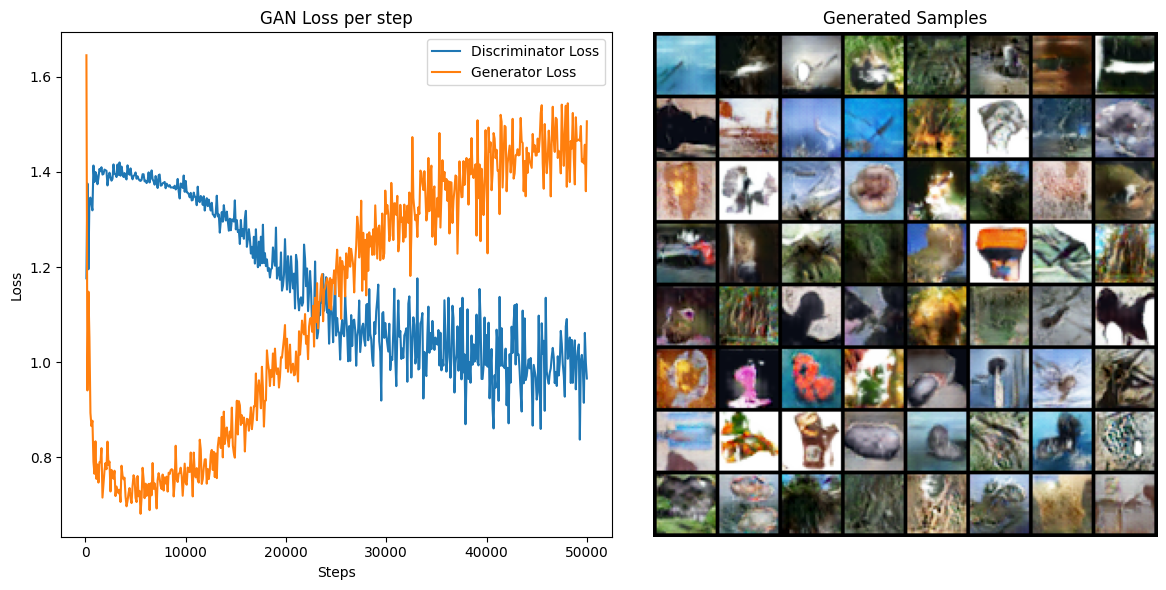

Steps 50000, D loss: 0.966, G loss: 1.506
Noise multiplier: 7.862781573797829e-08


In [10]:
import random

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)


def get_noise(step, initial=0.1, decay_rate=0.99):
    return initial * (decay_rate ** step)

all_steps = []
all_d_losses = []
all_g_losses = []
initial_noise = 0.25
decay_rate = 0.9997

while steps < 50000:
    
    d_losses = []
    g_losses = []
    noisemult = get_noise(steps, initial_noise, decay_rate)

    for i in range(100):

# discriminator training
        optimiserD.zero_grad()

        real_imgs, _ = next(train_iterator)
        real_imgs = real_imgs.to(device)
        real_noise = torch.randn_like(real_imgs) * noisemult
        noised_real_imgs = real_imgs + real_noise
        # sample from normal distribution 
        z = torch.randn(real_imgs.size(0), params["n_latent"], 1, 1, device=device)
        fake_imgs = G(z)
        fake_noise = torch.randn_like(fake_imgs) * noisemult
        noised_fake_imgs = fake_imgs + fake_noise

        if random.random() < 0.05:
            real_labels = torch.empty(real_imgs.size(0), 1, device=device).uniform_(0.0, 0.1)
        else:
            real_labels = torch.empty(real_imgs.size(0), 1, device=device).uniform_(0.9, 1.0)

        if random.random() < 0.05:
            fake_labels = torch.empty(fake_imgs.size(0), 1, device=device).uniform_(0.9, 1.0)
        else:
            fake_labels = torch.empty(fake_imgs.size(0), 1, device=device).uniform_(0.0, 0.1)

        real_validity = D(noised_real_imgs)
        d_real_loss = loss(real_validity, real_labels)

        fake_validity = D(noised_fake_imgs.detach())
        d_fake_loss = loss(fake_validity, fake_labels)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimiserD.step()

# generator training

        optimiserG.zero_grad()

        generated_validity = D(noised_fake_imgs)
        g_loss = loss(generated_validity, torch.empty(fake_imgs.size(0), 1, device=device).uniform_(0.9, 1.0))
        g_loss.backward()
        optimiserG.step()

        steps += 1
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    
    all_steps.append(steps)
    mean_d_loss = np.mean(d_losses)
    mean_g_loss = np.mean(g_losses)
    all_d_losses.append(mean_d_loss)
    all_g_losses.append(mean_g_loss)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot GAN Losses
    ax1.plot(all_steps, all_d_losses, '-', label='Discriminator Loss')
    ax1.plot(all_steps, all_g_losses, '-', label='Generator Loss')
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Loss")
    ax1.set_title("GAN Loss per step")
    ax1.legend(loc="upper right")

    # Generate samples
    G.eval()
    with torch.no_grad():
        z = torch.randn(params["batch_size"], params["n_latent"], device=device)
        z = z.view(z.size(0), params["n_latent"], 1, 1)
        samples = G(z).cpu()

    # Display generated samples
    samples_grid = torchvision.utils.make_grid(samples[:64]).numpy().transpose(1, 2, 0)
    ax2.imshow(samples_grid)
    ax2.axis("off")
    ax2.set_title("Generated Samples")

    plt.tight_layout()
    plt.show()
    # Print loss values
    
    print(f"Steps {steps}, D loss: {mean_d_loss:.3f}, G loss: {mean_g_loss:.3f}")
    print("Noise multiplier:", noisemult)
    disp.clear_output(wait=True)



**Latent interpolations**

In [ ]:
grid_size = 8

z0 = z[0:grid_size].repeat(grid_size, 1)
z1 = z[-grid_size:].repeat(grid_size, 1)

t = torch.linspace(0, 1, grid_size).unsqueeze(1).repeat(1, grid_size).view(grid_size * grid_size, 1).to(device)

lerp_z = (1 - t) * z0 + t * z1
lerp_g = G(lerp_z)

plt.rcParams['figure.dpi'] = 100
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_g, nrow=grid_size).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

**FID scores**

Evaluate the FID from 10k of your model samples (do not sample more than this) and compare it against the 10k test images. Calculating FID is somewhat involved, so we use a library for it. It can take a few minutes to evaluate. Lower FID scores are better.

In [215]:
import os
import shutil
from cleanfid import fid
from torchvision.utils import save_image


In [ ]:
# define directories

'''

All code within this block is the property of Amir-Atapour-Abarghouei

'''

real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # do not change

# create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Go back to original implementation when submitting
    os.makedirs(directory)

setup_directory(real_images_dir)
setup_directory(generated_images_dir)

# generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:

    # sample from your model, you can modify this
    z = torch.randn(params['batch_size'], params['n_latent']).to(device)
    samples_batch = G(z).cpu().detach()

    for image in samples_batch:
        if num_generated >= num_samples:
            break
        save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1

# save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1


In [217]:
# compute FID

score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean", num_workers=0)
print(f"FID score: {score}")


compute FID between two folders
Found 20000 images in the folder real_images


FID real_images : 100%|██████████| 625/625 [02:07<00:00,  4.91it/s]


Found 20000 images in the folder generated_images


FID generated_images : 100%|██████████| 625/625 [01:58<00:00,  5.26it/s]


FID score: 50.283123913007614
